In this file, I implement a basic XNOR model, and compare its performance to a standard convolutional network with a similar architecture. The original XNOR-Net paper can be found here: https://arxiv.org/pdf/1603.05279.pdf

MOTIVATION
The basic impulse behind many neural net models is to build bigger and bigger models to try to improve performance. This comes with some drawbacks: bigger models are bigger. With so many floating point parameters, they can take up immense amounts of room on the device running them. At some point, this makes bigger and higher performance models infeasible to run on weaker systems, including IOT devices, medical devices, and so on.

So we want a network with high performance but a smaller size. We have seen in this class a number of strategies that try to accomplish this through reducing the number of parameters required to achieve competitive performance, from parameter sharing with convolutions to pruning and so on. XNOR Net takes a different approach: it seeks to reduce the size of the model not by reducing the number of parameters but by reducing the size of the parameters from floating point numbers to binary values, which result in 32x memory savings. There are two ways of implementing this idea discussed in the paper: Binary-weights networks, where the network weights are binary but the input tensors are not, and XNOR-Networks, where both the input tensors and the weights are binary. I will be focusing on the XNOR case. Below are the building blocks needed to achieve this:

A binary convolution can be approximated by:

![EQN_1](eqn1.png)

Since the weights are binary, operations can be done with addition instead of multiplication.

We want to solve

![EQN_2](eqn2.png)

to estimate the the binary weights. With some math, we can show that the optimal estimation of the binary weight filter from a real-valued weight filter is just taking the sign of the weighted values.

To train the model, the paper states that weights can only be binarized during the forward pass and backwards propagation. When updating the weights, real-valued (32 bit floating point) weights must be used or else the model. The following algorithm is used to train the model:

![ALG_1](alg1.png)

The XNOR Net uses the following additional building blocks:
We need to approximate the dot product between the input X and weights W such that it can be approximated with

![EQN_3](eqn3.png)

To achieve this, we optimize

![EQN_5](eqn5.png)

by (10). 

![EQN_6](eqn6.png)

In the XNOR case, we can further approximate the binary convolution with

![EQN_7](eqn7.png)

On imagenet, the XNOR network performs about 10 percent below the binary weight network in top-1 and top-5, and about 16-18 percent behind a comparable full-precision network, despite massive space savings. A double-precision VGG-19 is about 1GB, but the binary version is only 16MB. A double precision ResNet-18 is about 100MB, but the binary version is only 1.5MB. These savings are immense.


To implement the XNOR-Net, I use the package available here:
https://github.com/yaysummeriscoming/BinaryNet_and_XNORNet/blob/master/BinaryNet.py

Below, I import some necessary packages.

In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import ndimage

import sys
import os
from PIL import Image
from glob import glob
import h5py
import time


Below, I perform some setup work. See the other file, dataset.ipynb, for more information on how I cleaned and formatted the data to get to this point. In short, the labels are stored in a dataframe that I load and extract the labels from below. I also do some work to create dictionaries to help me convert from class index to class name and vice versa. 

In [2]:
### pt 1
data_frame = pd.read_csv("../code5/data/dataset_df.csv").to_numpy()
print(data_frame.shape)

### pt 2
fullset_ids = np.arange(data_frame.shape[0])
np.random.shuffle(fullset_ids)

train_ids, val_ids = train_test_split(fullset_ids)

### pt 3
unique_vals = []
unique_counts = []
class_val = dict()
for i in range(data_frame.shape[0]):
    if data_frame[i, 2] not in unique_vals:
        unique_vals.append(data_frame[i, 2])
        unique_counts.append(1)
        class_val[data_frame[i, 2]] = len(unique_vals) - 1
    else:
        unique_counts[class_val[data_frame[i, 2]]] += 1

print(len(unique_vals), "classes")

for i in range(len(unique_vals)):
    print(unique_vals[i], " - ", unique_counts[i])

(40000, 4)
50 classes
4286 roof tile 1x3  -  800
3045 roof corner outside tile 2x2  -  800
3068 flat tile 2x2  -  800
3021 plate 2x3  -  800
2780 Peg with friction  -  800
6632 lever 3M  -  800
3002 brick 2x3  -  800
3675 roof tile outside 3x3  -  800
3024 plate 1x1  -  800
3062 Round Brick 1x1  -  800
14719 flat tile corner 2x2  -  800
43857 beam 1x2  -  800
27925 flat tile round 2x2  -  800
3623 Plate 1x3  -  800
6143 Brick D16 w cross  -  800
3005 brick 1x1  -  800
3004 brick 1x2  -  800
3010 brick 1x4  -  800
41677 lever 2M  -  800
54200 roof tile 1x1  -  800
85984 roof tile 1x2  -  800
4490 brick bow 1x3  -  800
18654 beam 1M  -  800
3001 brick 2x4  -  800
3003 brick 2x2  -  800
3022 Plate 2x2  -  800
43093 Bush 2M friction - Cross axle  -  800
3038 roof tile 2x3  -  800
3023 Plate 1x2  -  800
3794 Plate 1X2 with 1 Knob  -  800
3037 roof tile 1x4  -  800
3020 plate 2x4  -  800
2420 plate corner 2x2  -  800
41678 Cross Block Fork 2x2  -  800
99301 roof tile inside 3x3  -  800
15672

Below, I import some stuff needed for the model.

In [3]:
import tensorflow as tf
import tensorflow.keras.layers
import tensorflow.keras.utils as kr_utils
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, MaxPooling2D, Add, BatchNormalization, Dropout, Flatten, Input, InputLayer, Conv2D, ReLU, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import ModelCheckpoint
import math

Below, I define a special callback function to help me track performance across training epochs:

In [ ]:
class lossCallback(tf.keras.callbacks.Callback):
    def __init__ (self):
        self.logs = dict()
        self.init = False
        self.lasttime = -1

    def on_epoch_end(self, epoch, logs={}):
        keys = list(logs.keys())
        if not self.init:
            for k in keys:
                self.logs[k] = []
            self.init = True
            self.logs["time"] = []
        #['loss', 'accuracy', 'val_loss', 'val_accuracy']
        #print("CALLBACK: epoch", epoch, "keys:", keys)
        ctime = time.time()
        if self.lasttime == -1:
            ttime = 0
        else:
            ttime = ctime - self.lasttime
        self.logs["time"].append(ttime)
        self.lasttime = ctime
        for k in keys:
            self.logs[k].append(logs.get(k))
        

Below, I define a class to help manage the data. I have almost 80GB of images in the dataset – I cannot possibly load them all into memory to train. I thus gathered all the images in one large h5 file in the other file, dataset.ipynb. This allows for quicker loading from the disk. Within the class below, I handle batch loading the data and various other things.

In [5]:
class datagen(tensorflow.keras.utils.Sequence):
    def __init__ (self, img_source, labels, batch_size=32, dim_out=(384, 384, 3),
                  base_dim=(400, 400, 3), shuffle=True, rmode=True, h5mode=True, subset=None):
        self.img_ref = img_source
        self.y = labels
        self.batch_size = batch_size
        self.img_dim = dim_out
        self.rmode = rmode

        self.shuffle = shuffle

        self.index = np.arange(len(self.y))
        self.on_epoch_end()

        self.h5mode = h5mode
        if self.h5mode:
            self.use_ids = subset
            self.h5_src = h5py.File('../code5/data/x_h5.h5','r')
            self.h5_dataset = self.h5_src["data"]
            print("h5 shape:", self.h5_dataset.shape)
        #self.h5_dset(img_source)

        self.dim0_slack = base_dim[0] - dim_out[0]
        self.dim1_slack = base_dim[1] - dim_out[1]

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def loadimg(self, fname):
        if self.h5mode:
            return np.array(self.h5_dataset[fname])
        else:
            return cv2.imread(fname)

    def __getitem__(self, idx):
        ### this section inspired by tutorial from stanford:
        ### https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        # Generate indexes of the batch
        #indexes = self.index[indexi*self.batch_size:(indexi+1)*self.batch_size]
        ret_indices = self.index[idx * self.batch_size: min(((idx+1) * self.batch_size), len(self.index))]

        # Generate data
        X, y = self.__data_generation(ret_indices)

        return X, y

    def __data_generation(self, list_IDs_temp):
        x_out = np.empty((self.batch_size, self.img_dim[0], self.img_dim[1], self.img_dim[2]))
        y_out = np.empty((self.batch_size,), dtype=int)

        for i in range(len(list_IDs_temp)):
            if self.rmode:
                r0 = np.random.randint(0, self.dim0_slack)
                r1 = np.random.randint(0, self.dim1_slack)
            else:
                r0 = 0
                r1 = 0 
            if self.h5mode:
                x_out[i,:,:,:] = self.loadimg(self.use_ids[list_IDs_temp[i]])[r0:r0+self.img_dim[0], r1:r1+self.img_dim[1],:]
            else:
                x_out[i,:,:,:] = self.loadimg(self.img_ref[list_IDs_temp[i]])[r0:r0+self.img_dim[0], r1:r1+self.img_dim[1],:]
            y_out[i] = self.y[list_IDs_temp[i]]
        return x_out, np.reshape(y_out, (-1, 1))

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.index)

Below, I take a subset of the data containing only the first several labels to make this computationally feasible on my slow laptop. 

In [6]:
cutto = 3

train_ss = []
for elt in train_ids:
    if data_frame[elt, 2] in unique_vals[:cutto]:
        train_ss.append(elt)

train_ss = np.array(train_ss)

val_ss = []
for elt in val_ids:
    if data_frame[elt, 2] in unique_vals[:cutto]:
        val_ss.append(elt)

val_ss = np.array(val_ss)

train = datagen(data_frame[train_ss, 1], data_frame[train_ss, 3], h5mode=True, subset=train_ss)
test = datagen(data_frame[val_ss, 1], data_frame[val_ss, 3], h5mode=True, subset=val_ss)
print(train[0][0].shape)
print(len(train_ids))
print(len(val_ids))

h5 shape: (40000, 400, 400, 3)
h5 shape: (40000, 400, 400, 3)
(32, 384, 384, 3)
30000
10000


Below, I make a directory to save models into.

In [7]:
os.system("mkdir model_saves")
saveloc = "./model_saves"

mkdir: model_saves: File exists


Below, I import some stuff for the XNOR-Net

In [8]:
sys.path.insert(0, './BinaryNet_and_XNORNet')
from CompositeLayers.ConvBNReluLayer import ConvBNReluLayer
from CompositeLayers.BinaryNetConvBNReluLayer import BinaryNetConvBNReluLayer, BinaryNetActivation
from CustomLayers.CustomLayersDictionary import customLayersDictionary
from CompositeLayers.XNORConvLayer import XNORConvBNReluLayer, BNXNORConvReluLayer
from NetworkParameters import NetworkParameters
from CustomLayers.CustomLayersDictionary import customLayerCallbacks

Below, I initialize the basic XNOR model. This contains 5 binary XNOR convolutions.

In [9]:
### do an xnor net
sq_in = Input(shape=(384, 384, 3))
sq = sq_in
sq = ConvBNReluLayer(input=sq, nb_filters=16, border='valid', kernel_size=(3, 3), stride=(1, 1))
sq = BNXNORConvReluLayer(input=sq, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
sq = BNXNORConvReluLayer(input=sq, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
sq = BNXNORConvReluLayer(input=sq, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
sq = BNXNORConvReluLayer(input=sq, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
sq = BNXNORConvReluLayer(input=sq, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))

sq = Flatten()(sq)
sq = Dense(cutto, use_bias=True, activation='softmax')(sq)

xnormodel = Model(inputs=sq_in, outputs=sq)

2022-11-14 10:14:47.182496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compile the model:

In [10]:
print(xnormodel.summary())
xnormodel.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 382, 382, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 382, 382, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 382, 382, 16)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 382, 382, 16)     64        
 hNormalization)                                                 
                                                                 
 xnor_net_conv2d (XNORNetCon  (None, 380, 380, 32)     4617  

Initialize some callbacks to keep track of the model:

In [11]:
callbacksx = []
cbx_checkpt = ModelCheckpoint(saveloc + "xnor_checkpoint.h5",
                    verbose=2,
                    save_best_only=True,
                    save_freq="epoch",
                    save_weights_only = True)
cbx_losscb = lossCallback()
callbacksx.append(cbx_checkpt)
callbacksx.append(cbx_losscb)

Fit the model:

In [12]:
xnormodel.fit(train, callbacks=callbacksx, epochs=5, verbose=1, validation_data=test)

Epoch 1/5
56/56 [==============================] - ETA: 0s - loss: 4.9045 - accuracy: 0.3281 
Epoch 1: val_loss improved from inf to 2.27713, saving model to ./model_savesxnor_checkpoint.h5
56/56 [==============================] - 1335s 24s/step - loss: 4.9045 - accuracy: 0.3281 - val_loss: 2.2771 - val_accuracy: 0.1875
Epoch 2/5
56/56 [==============================] - ETA: 0s - loss: 1.9159 - accuracy: 0.3253 
Epoch 2: val_loss did not improve from 2.27713
56/56 [==============================] - 1025s 18s/step - loss: 1.9159 - accuracy: 0.3253 - val_loss: 2.9183 - val_accuracy: 0.2743
Epoch 3/5
56/56 [==============================] - ETA: 0s - loss: 1.9060 - accuracy: 0.3242 
Epoch 3: val_loss did not improve from 2.27713
56/56 [==============================] - 1051s 19s/step - loss: 1.9060 - accuracy: 0.3242 - val_loss: 2.4108 - val_accuracy: 0.6597
Epoch 4/5
56/56 [==============================] - ETA: 0s - loss: 2.7787 - accuracy: 0.3292 
Epoch 4: val_loss did not improve from

Initialize a standard CNN with similar architecture, compile and train it:

In [16]:
sq1_in = Input(shape=(384, 384, 3))
sq1 = sq1_in
sq1 = Conv2D(filters=16, padding='valid', kernel_size=(3, 3), strides=(1, 1))(sq1)
sq1 = Conv2D(filters=32, padding='valid', kernel_size=(3, 3), strides=(1, 1))(sq1)
sq1 = Conv2D(filters=32, padding='valid', kernel_size=(3, 3), strides=(1, 1))(sq1)
sq1 = Conv2D(filters=32, padding='valid', kernel_size=(3, 3), strides=(1, 1))(sq1)
sq1 = Conv2D(filters=32, padding='valid', kernel_size=(3, 3), strides=(1, 1))(sq1)
sq1 = Conv2D(filters=32, padding='valid', kernel_size=(3, 3), strides=(1, 1))(sq1)

sq1 = Flatten()(sq1)
sq1 = Dense(cutto, use_bias=True, activation='softmax')(sq1)

convmodel = Model(inputs=sq1_in, outputs=sq1)

print(convmodel.summary())
convmodel.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

callbacksc = []
cbc_checkpt = ModelCheckpoint(saveloc + "sqz3_checkpoint.h5",
                    verbose=2,
                    save_best_only=True,
                    save_freq="epoch",
                    save_weights_only = True)
cbc_losscb = lossCallback()
callbacksc.append(cbc_checkpt)
callbacksc.append(cbc_losscb)

convmodel.fit(train, callbacks=callbacksc, epochs=5, verbose=1, validation_data=test)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 382, 382, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 380, 380, 32)      4640      
                                                                 
 conv2d_4 (Conv2D)           (None, 378, 378, 32)      9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 376, 376, 32)      9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 374, 374, 32)      9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 372, 372, 32)      9248

Try to fit both of the models for a few additional epochs, time permitting:

In [28]:
xnormodel.fit(train, callbacks=callbacksx, epochs=45, verbose=1, validation_data=test)
convmodel.fit(train, callbacks=callbacksc, epochs=45, verbose=1, validation_data=test)

Epoch 1/45
56/56 [==============================] - ETA: 0s - loss: 1.5268 - accuracy: 0.3298 
Epoch 1: val_loss did not improve from 2.27713
56/56 [==============================] - 1479s 27s/step - loss: 1.5268 - accuracy: 0.3298 - val_loss: 11.7756 - val_accuracy: 0.0000e+00
Epoch 2/45
34/56 [=================>............] - ETA: 9:22 - loss: 1.2031 - accuracy: 0.3162

Plot the validation accuracy and training loss on the same axis for the XNOR model:
After 3 epochs the validation accuracy drops to 0 and doesn/t recover. A similar phenomenon has occured over a number of restarts -- I am not really sure what is going on here

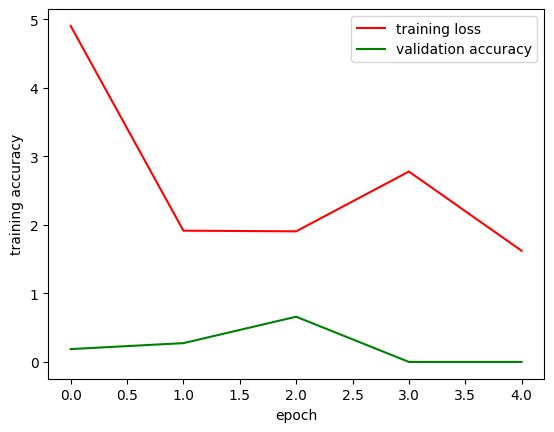

In [20]:
import matplotlib.pyplot as plt
x_plt_data = np.arange(5) ### epoch indices
mdlx_loss = cbx_losscb.logs['loss']
mdlx_val_acc = cbx_losscb.logs['val_accuracy']
fig, ax = plt.subplots()
ax.plot(x_plt_data, mdlx_loss, color='red', label='training loss')
ax.plot(x_plt_data, mdlx_val_acc, color='green', label='validation accuracy')
ax.set(xlabel = 'epoch', ylabel = 'training accuracy')
plt.legend()
plt.show()

The training loss and validation accuracy for the basic model. The scale distorts this, but the basic model's validation accuracy curve is better than that of the XNOR model, which is unsurprising given the results from the paper discussed above.

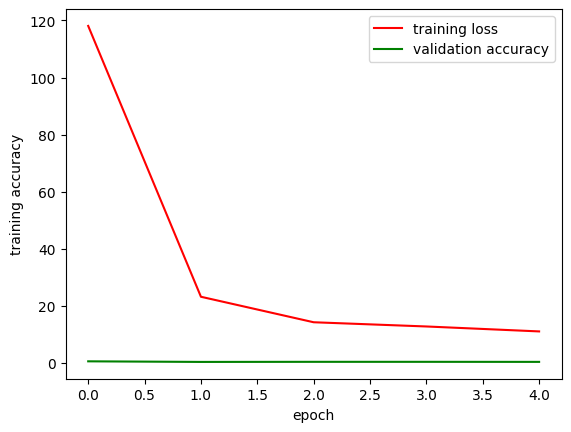

In [21]:
mdlc_loss = cbc_losscb.logs['loss']
mdlc_val_acc = cbc_losscb.logs['val_accuracy']
fig, ax = plt.subplots()
ax.plot(x_plt_data, mdlc_loss, color='red', label='training loss')
ax.plot(x_plt_data, mdlc_val_acc, color='green', label='validation accuracy')
ax.set(xlabel = 'epoch', ylabel = 'training accuracy')
plt.legend()
plt.show()

Below, the training time for each of the models. It is unclear to me if my laptop is heat throttling or anything but the xnor model takes far longer to train despite claims in the paper that it should be faster. This likely comes down to a slow or somehow unoptimized implementation of the model.

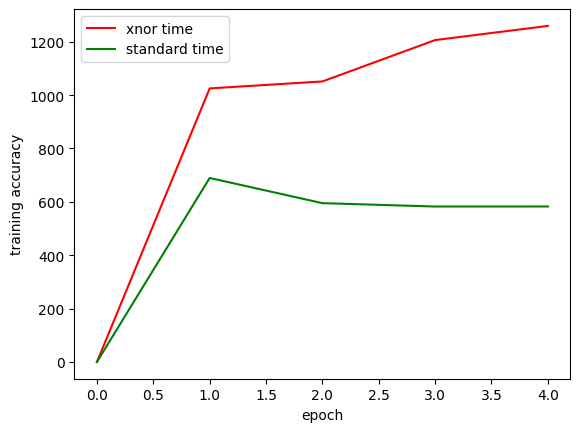

In [23]:
ctime = cbc_losscb.logs['time']
xtime = cbx_losscb.logs['time']
fig, ax = plt.subplots()
ax.plot(x_plt_data, xtime, color='red', label='xnor time')
ax.plot(x_plt_data, ctime, color='green', label='standard time')
ax.set(xlabel = 'epoch', ylabel = 'train time')
plt.legend()
plt.show()


Below, a comparison of the size on disk of both models. The XNOR model is actually 0.1 MB larger -- My best guess as to why this is happening is that keras is saving the weights as floating point numbers instead of binary weights. This is something I believe could be fixed with additional knowledge of how checkpoints work in Keras.

[Text(0.5, 0, 'model'), Text(0, 0.5, 'model size')]

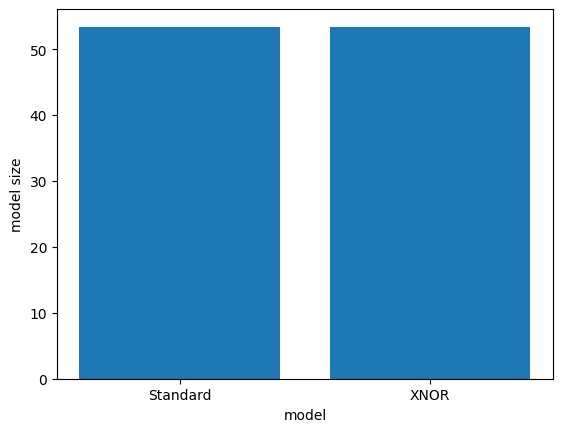

In [25]:
fig, ax = plt.subplots()
ax.bar(["Standard", "XNOR"], [53.3, 53.4])
ax.set(xlabel = 'model', ylabel = 'model size (MB)')


Below, I try to get a sense for the size in memory of each of the models, but this is unhelpful because it seems that this number is only measuring the size of the immediate item in memory but does not take into account any further objects that may be referenced recursively.

In [27]:
print(sys.getsizeof(xnormodel))
print(sys.getsizeof(convmodel))

48
48
